<a href="https://colab.research.google.com/github/ShawnLiu119/CapstoneProject_BankingMarketing/blob/main/BankMkting_classificationmodelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd 
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,r2_score
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
import warnings
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [3]:
import pandas as pd

In [4]:
url = 'https://raw.githubusercontent.com/ShawnLiu119/CapstoneProject_BankingMarketing/main/rawdata/bank-additional-full.csv'
data = pd.read_csv(url, sep=';')

### General Function Setup

In [5]:
#one hot encoding function
def one_hot(df):
    y = df['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
    x = df.drop('y', axis=1)
    x_dum = pd.get_dummies(x)
    return x, y


#train_test_split
def scale_split(x, y, test_size):
    scaler = MinMaxScaler()
    df_sca = scaler.fit_transform(x)
    x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = test_size, random_state=42)
    print(x_train.shape, x_test.shape,y_train.shape,y_test.shape)
    return x_train,x_test,y_train,y_test
   



### Data Transformation - V1 (Agreed on Team Discussion)

In [6]:
data['education'].value_counts()

data_1 = data.copy()
data_1 = data_1[data_1['education'] != 'illiterate']

data_1['edu_new'] = data_1['education'].map({'basic.4y': 'pre_high', 
                                         'basic.9y': 'pre_high',
                                         'basic.6y': 'pre_high',
                                         'university.degree' : 'post_high',
                                         'professional.course':'post_high',
                                         'high.school' : 'high',
                                         'unknown' :'unknown' })

In [7]:
def map_job(row):
    if row['job'] in ['admin.', 'management', 'entrepreneur','self-employed']:
        cat = 'white_collar'
    elif row['job'] in ['housemaid', 'blue-collar', 'technician', 'services']:
        cat = 'blue_collar'
    elif row['job'] in ['student', 'retired', 'unemployed']:
        cat = 'not_working'
    else:
        cat = 'unknown'
    return cat

data_1['job_new'] = data_1.apply(map_job, axis=1)
data_1['job_new'].value_counts(dropna = False)

blue_collar     21017
white_collar    16217
not_working      3606
unknown           330
Name: job_new, dtype: int64

In [8]:
def map_month(row):
    if row['month'] in ['mar', 'apr', 'may']:
        cat = 'spring'
    elif row['month'] in ['jun', 'jul', 'aug']:
        cat = 'summer'
    elif row['month'] in ['sep', 'oct', 'nov']:
        cat = 'fall'
    else:
        cat = 'winter'
    return cat

data_1['season'] = data_1.apply(map_month, axis=1)
data_1['season'].value_counts(dropna = False)

summer    18660
spring    16942
fall       5386
winter      182
Name: season, dtype: int64

In [9]:
data_1.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'edu_new', 'job_new',
       'season'],
      dtype='object')

In [10]:
#This transformed dataframe is based on group discussion on 7/23
# - keep all numerical features as they are
# - consolidate categorical features (education, job, season) and drop originial ones

df_tran_1 = data_1[['age', 'marital', 'default', 'housing', 'loan',
       'contact', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'edu_new', 'job_new', 'season']]

In [11]:
df_tran_1.shape
#this is because we removed illiterate

(41170, 21)

In [12]:
df_tran_1 = df_tran_1.drop(['duration'], axis=1)
df_tran_1.columns

Index(['age', 'marital', 'default', 'housing', 'loan', 'contact',
       'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y', 'edu_new', 'job_new', 'season'],
      dtype='object')

### One Hot Encoding For Categorical Features

In [13]:
y = df_tran_1['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
y.value_counts()

0    36534
1     4636
Name: y, dtype: int64

In [14]:
x = df_tran_1.drop('y', axis=1)

In [15]:
df_raw = pd.get_dummies(x)
df_raw.columns

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success', 'edu_new_high',
       'edu_new_post_high', 'edu_new_pre_high', 'edu_new_unknown',
       'job_new_blue_collar', 'job_new_not_working', 'job_new_unknown',
       'job_new_white_collar', 'season_fall', 'season_spring', 'season_summer',
       'season_winter'],
      dtype='object')

In [16]:
#drop the unknow columns as they are correlated to other categories

df_raw = df_raw.drop(['marital_unknown', 'default_unknown', 'housing_unknown', 'loan_unknown', 'edu_new_unknown', 'job_new_unknown'], axis=1)
df_raw.shape

(41170, 38)

### Train-Test Split & Data Normalization

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_raw = scaler.fit_transform(df_raw)

In [18]:
df_raw

array([[0.48148148, 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [0.49382716, 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [0.24691358, 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.48148148, 0.01818182, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.33333333, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.7037037 , 0.03636364, 1.        , ..., 0.        , 0.        ,
        0.        ]])

In [19]:
#here i used stratified sampling approach, since the raw data is not balanced distributed
x_train,x_test,y_train,y_test = train_test_split(df_raw, y, test_size = 0.2, stratify=y, random_state=42)
print(x_train.shape,
      x_test.shape,
      y_train.shape,
      y_test.shape)

(32936, 38) (8234, 38) (32936,) (8234,)


### Balancing the data using SMOTE

https://towardsdatascience.com/all-about-imbalanced-machine-learning-classifiers-60563014d2b3


In [20]:
pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 16.0 MB/s 
     |████████████████████████████████| 199 kB 41.3 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [21]:
import imblearn

smote = SMOTE()

x_s, y_s = smote.fit_resample(x_train, y_train)

print('Original dataset shape', len(x_train))
print('Resampled dataset shape', len(x_s))

Original dataset shape 32936
Resampled dataset shape 58454


In [22]:
y_s.value_counts()

0    29227
1    29227
Name: y, dtype: int64

### Classification with Neural Network

In [27]:
model = Sequential()
model.add(Dense(units = 16, kernel_initializer = 'he_uniform',activation='relu',input_dim = x_s.shape[1]))
model.add(Dense(units = 8, kernel_initializer = 'he_uniform',activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

may need to revisit the kernel initialization and tweaking the model
here is the reference:https://www.kaggle.com/code/trolukovich/glorot-vs-he-weight-initialization-experiment/notebook

In [28]:
model.compile(optimizer = 'adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                624       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [29]:
model_history = model.fit(x_s, y_s,validation_split=0.33, batch_size = 10, epochs = 100)

Epoch 1/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.5205 - accuracy: 0.7703 - val_loss: 1.1190 - val_accuracy: 0.4023
Epoch 2/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4738 - accuracy: 0.8019 - val_loss: 1.0952 - val_accuracy: 0.4083
Epoch 3/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4668 - accuracy: 0.8035 - val_loss: 1.0569 - val_accuracy: 0.4253
Epoch 4/100
3917/3917 [==============================] - 8s 2ms/step - loss: 0.4635 - accuracy: 0.8047 - val_loss: 1.0573 - val_accuracy: 0.4261
Epoch 5/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4603 - accuracy: 0.8052 - val_loss: 1.0669 - val_accuracy: 0.4300
Epoch 6/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4586 - accuracy: 0.8070 - val_loss: 1.0200 - val_accuracy: 0.4484
Epoch 7/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4571 - accuracy: 0.8065 - val_loss: 1.0939 - val_ac

In [43]:
from sklearn.metrics import mean_squared_error as MSE
# define functions for model performance evaluation
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [31]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

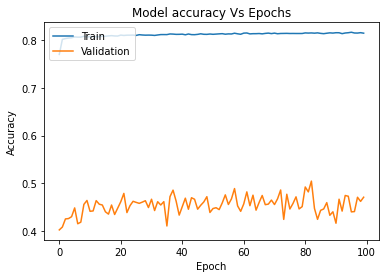

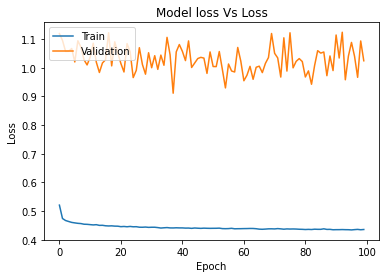

In [32]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy Vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss Vs Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [33]:
loss, accuracy = model.evaluate(x_test, y_test)

258/258 [==============================] - 1s 2ms/step - loss: 0.3167 - accuracy: 0.8888


In [40]:
preds = model.predict(x_test)
preds=np.argmax(preds, axis=1)
print('shape of preds: ', preds.shape)

shape of preds:  (8234,)


In [44]:
print_validation_report(y_test, preds)

Classification Report
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7307
           1       0.00      0.00      0.00       927

    accuracy                           0.89      8234
   macro avg       0.44      0.50      0.47      8234
weighted avg       0.79      0.89      0.83      8234

Accuracy Score: 0.8874180228321593
Root Mean Square Error: 0.33553237871752506


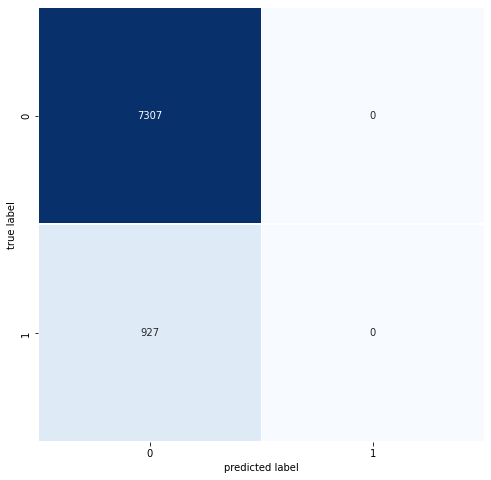

In [46]:
plot_confusion_matrix(y_test,preds)

### train NN on the dataset by removing unknowns and days-of-week

In [47]:
df_raw_2 = pd.get_dummies(x)

df_raw_2 = df_raw_2.drop(['marital_unknown', 'default_unknown', 'housing_unknown', 
                        'loan_unknown', 'edu_new_unknown', 'job_new_unknown',
                        'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
                        'day_of_week_tue', 'day_of_week_wed', 'season_winter'], axis=1)
df_raw_2.shape

(41170, 32)

In [48]:
scaler = MinMaxScaler()
x_2 = scaler.fit_transform(df_raw_2)

In [49]:
x_train2,x_test2,y_train2,y_test2 = train_test_split(x_2, y, test_size = 0.2, random_state=42)
#take out stratify approach
print(x_train2.shape,
      x_test2.shape,
      y_train2.shape,
      y_test2.shape)

(32936, 32) (8234, 32) (32936,) (8234,)


In [50]:
smote = SMOTE()

x_s2, y_s2 = smote.fit_resample(x_train2, y_train2)

print('Original dataset shape', len(x_train2))
print('Resampled dataset shape', len(x_s2))

Original dataset shape 32936
Resampled dataset shape 58454


In [55]:
model2 = Sequential()
model2.add(Dense(units = 16, activation='relu',input_dim = x_s2.shape[1]))
model2.add(Dense(units = 8 ,activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(Dropout(0.2))
model2.add(Dense(units = 1, activation = 'sigmoid'))

In [56]:
model2.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 16)                528       
                                                                 
 dense_12 (Dense)            (None, 8)                 136       
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________


In [57]:
model_history = model2.fit(x_s2, y_s2,validation_split=0.33, batch_size = 10, epochs = 100)

Epoch 1/100
3917/3917 [==============================] - 11s 2ms/step - loss: 0.4633 - accuracy: 0.8043 - val_loss: 0.9655 - val_accuracy: 0.4600
Epoch 2/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4501 - accuracy: 0.8125 - val_loss: 1.1008 - val_accuracy: 0.4426
Epoch 3/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4474 - accuracy: 0.8142 - val_loss: 1.0383 - val_accuracy: 0.4555
Epoch 4/100
3917/3917 [==============================] - 8s 2ms/step - loss: 0.4467 - accuracy: 0.8139 - val_loss: 1.0613 - val_accuracy: 0.4445
Epoch 5/100
3917/3917 [==============================] - 10s 2ms/step - loss: 0.4465 - accuracy: 0.8141 - val_loss: 1.1734 - val_accuracy: 0.4137
Epoch 6/100
3917/3917 [==============================] - 11s 3ms/step - loss: 0.4459 - accuracy: 0.8144 - val_loss: 1.0619 - val_accuracy: 0.4361
Epoch 7/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4451 - accuracy: 0.8154 - val_loss: 0.9872 - val

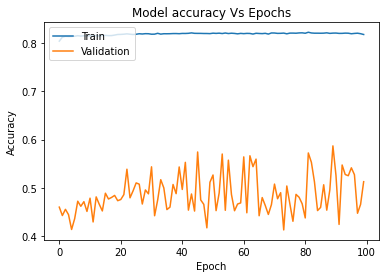

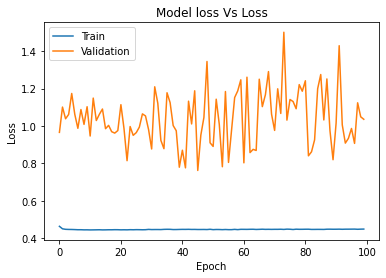

In [58]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy Vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss Vs Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [60]:
loss, accuracy = model2.evaluate(x_test2, y_test2)

258/258 [==============================] - 1s 4ms/step - loss: 0.3298 - accuracy: 0.8816


In [61]:
preds2 = model2.predict(x_test2)
preds2=np.argmax(preds2, axis=1)
print('shape of preds: ', preds.shape)

shape of preds:  (8234,)


In [62]:
print_validation_report(y_test2, preds2)

Classification Report
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7307
           1       0.00      0.00      0.00       927

    accuracy                           0.89      8234
   macro avg       0.44      0.50      0.47      8234
weighted avg       0.79      0.89      0.83      8234

Accuracy Score: 0.8874180228321593
Root Mean Square Error: 0.33553237871752506


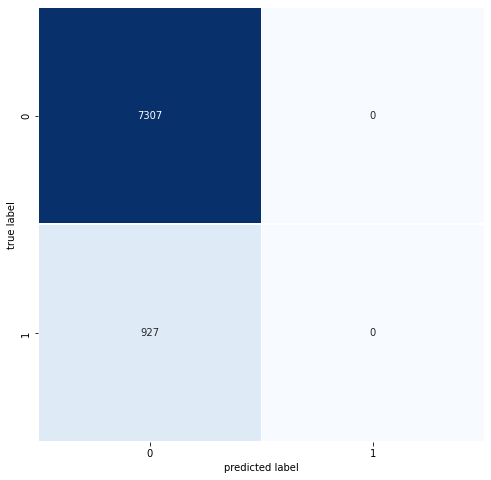

In [63]:
plot_confusion_matrix(y_test2,preds2)

###Train the model with duration feature - comparison purpose

In [64]:
data_dur = data_1.copy()

In [65]:
df_dur = data_dur[['age', 'marital', 'default', 'housing', 'loan',
       'contact', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'edu_new', 'job_new', 'season']]

In [ ]:
y = df_dur['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
y.value_counts()

In [67]:
x = df_dur.drop('y', axis=1)

In [68]:
df_raw_3 = pd.get_dummies(x)
df_raw_3.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success', 'edu_new_high',
       'edu_new_post_high', 'edu_new_pre_high', 'edu_new_unknown',
       'job_new_blue_collar', 'job_new_not_working', 'job_new_unknown',
       'job_new_white_collar', 'season_fall', 'season_spring', 'season_summer',
       'season_winter'],
      dtype='object')

In [69]:
#drop the unknow columns as they are correlated to other categories

df_raw_3 = df_raw_3.drop(['marital_unknown', 'default_unknown', 'housing_unknown', 
                        'loan_unknown', 'edu_new_unknown', 'job_new_unknown',
                        'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
                        'day_of_week_tue', 'day_of_week_wed', 'season_winter'], axis=1)
df_raw_3.shape

(41170, 33)

In [70]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_3 = scaler.fit_transform(df_raw_3)

In [71]:
x_3

array([[0.48148148, 0.05307035, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.49382716, 0.03029687, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.24691358, 0.04595364, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.48148148, 0.03843026, 0.01818182, ..., 1.        , 0.        ,
        0.        ],
       [0.33333333, 0.08987393, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.7037037 , 0.04859699, 0.03636364, ..., 1.        , 0.        ,
        0.        ]])

In [72]:
#here i used stratified sampling approach, since the raw data is not balanced distributed
x_train3,x_test3,y_train3,y_test3 = train_test_split(x_3, y, test_size = 0.2, stratify=y, random_state=42)
print(x_train3.shape,
      x_test3.shape,
      y_train3.shape,
      y_test3.shape)

(32936, 33) (8234, 33) (32936,) (8234,)


In [73]:
import imblearn

smote = SMOTE()

x_s3, y_s3 = smote.fit_resample(x_train3, y_train3)

print('Original dataset shape', len(x_train3))
print('Resampled dataset shape', len(x_s3))

Original dataset shape 32936
Resampled dataset shape 58454


In [74]:
y_s3.value_counts()

0    29227
1    29227
Name: y, dtype: int64

In [77]:
model3 = Sequential()
model3.add(Dense(units = 16, kernel_initializer = 'he_uniform',activation='relu',input_dim = x_s3.shape[1]))
model3.add(Dense(units = 8, kernel_initializer = 'he_uniform',activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model3.add(Dropout(0.2))
model3.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

In [79]:
model3.compile(optimizer = 'adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 16)                544       
                                                                 
 dense_18 (Dense)            (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 689
Trainable params: 689
Non-trainable params: 0
_________________________________________________________________


In [80]:
model_history = model3.fit(x_s3, y_s3,validation_split=0.33, batch_size = 10, epochs = 100)

Epoch 1/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4902 - accuracy: 0.7890 - val_loss: 0.9856 - val_accuracy: 0.4475
Epoch 2/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.4224 - accuracy: 0.8160 - val_loss: 0.8085 - val_accuracy: 0.5251
Epoch 3/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.3583 - accuracy: 0.8400 - val_loss: 0.6859 - val_accuracy: 0.6417
Epoch 4/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.3228 - accuracy: 0.8588 - val_loss: 0.6096 - val_accuracy: 0.7239
Epoch 5/100
3917/3917 [==============================] - 9s 2ms/step - loss: 0.3100 - accuracy: 0.8656 - val_loss: 0.6349 - val_accuracy: 0.7250
Epoch 6/100
3917/3917 [==============================] - 10s 3ms/step - loss: 0.3033 - accuracy: 0.8698 - val_loss: 0.5197 - val_accuracy: 0.8158
Epoch 7/100
3917/3917 [==============================] - 8s 2ms/step - loss: 0.2993 - accuracy: 0.8706 - val_loss: 0.6350 - val_a

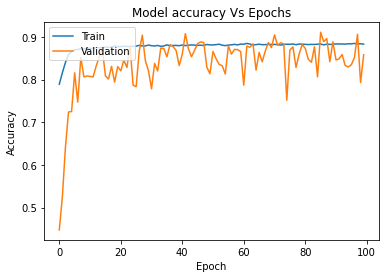

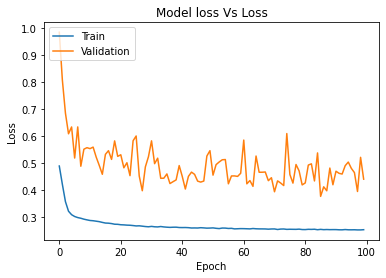

In [81]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy Vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss Vs Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [82]:
loss, accuracy = model3.evaluate(x_test3, y_test3)

258/258 [==============================] - 1s 4ms/step - loss: 0.2146 - accuracy: 0.8911


In [83]:
preds3 = model3.predict(x_test3)
preds3=np.argmax(preds3, axis=1)
print('shape of preds: ', preds.shape)

shape of preds:  (8234,)


In [84]:
print_validation_report(y_test3, preds3)

Classification Report
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7307
           1       0.00      0.00      0.00       927

    accuracy                           0.89      8234
   macro avg       0.44      0.50      0.47      8234
weighted avg       0.79      0.89      0.83      8234

Accuracy Score: 0.8874180228321593
Root Mean Square Error: 0.33553237871752506


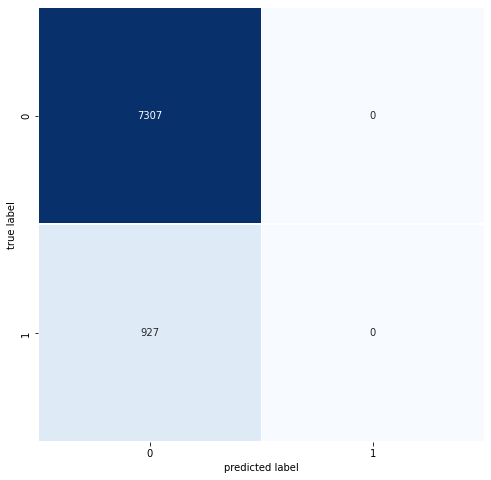

In [85]:
plot_confusion_matrix(y_test3,preds3)

### Train NN based on original dataset for comparison purpose without duration

In [ ]:
data_2 = data.copy()
df_tran_2 = data_2.drop(['duration'], axis=1)
df_tran_2.columns

In [ ]:
y = df_tran_2['y'].apply(lambda x: 0 if x=='no' else (1 if x=='yes' else -1))
y.value_counts()

In [ ]:
x = df_tran_2.drop('y', axis=1)

In [ ]:
df_raw_3 = pd.get_dummies(x)
df_raw_3.columns

In [ ]:
#drop the unknow columns as they are correlated to other categories

df_raw_3 = df_raw_3.drop(['job_unknown','marital_unknown','education_unknown', 'default_unknown', 'housing_unknown', 'loan_unknown'], axis=1)
df_raw_3.shape

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_raw_3 = scaler.fit_transform(df_raw_3)

In [ ]:
df_raw_3

In [ ]:
#here i used stratified sampling approach, since the raw data is not balanced distributed
x_train3,x_test3,y_train3,y_test3 = train_test_split(df_raw_3, y, test_size = 0.2, stratify=y, random_state=42)
print(x_train3.shape,
      x_test3.shape,
      y_train3.shape,
      y_test3.shape)

In [ ]:
import imblearn

smote = SMOTE()

x_s3, y_s3 = smote.fit_resample(x_train3, y_train3)

print('Original dataset shape', len(x_train3))
print('Resampled dataset shape', len(x_s3))

In [ ]:
model3 = Sequential()
model3.add(Dense(units = 16, kernel_initializer = 'he_uniform',activation='relu',input_dim = x_s3.shape[1]))
model3.add(Dense(units = 8, kernel_initializer = 'he_uniform',activation='relu'))
model3.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

In [ ]:
model3.compile(optimizer = 'adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])
model3.summary()

In [ ]:
model_history = model3.fit(x_s3, y_s3,validation_split=0.33, batch_size = 10, epochs = 100)

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy Vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss Vs Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [89]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = data_1.select_dtypes(include=numerics)

In [99]:
df = pd.DataFrame(df_num.describe())
df = df.reset_index()

# Use Sisense for Cloud Data Teams to visualize a dataframe by passing the data to periscope.output()

df


,index,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,count,41170.000000,41170.000000,41170.000000,41170.000000,41170.000000,41170.000000,41170.000000,41170.000000,41170.000000,41170.000000
1,mean,40.020355,258.276925,2.567719,962.483605,0.172990,0.081980,93.575777,-40.502842,3.621337,5167.033838
2,std,10.419647,259.262586,2.770421,186.890849,0.494964,1.570904,0.578798,4.627973,1.734444,72.255836
3,min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
4,25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
5,50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
6,75%,47.000000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
7,max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Data Transformation - V2 (Shawn's attempt based on FAMDD analysis)
##### if you are focusing on the agreed v1, feel free to skip this part, just want to experiment, may not have too signficant impact

In [ ]:
data_2 = data.copy()

In [ ]:
#findings from FAMD analysis
# there is significant distinguishablity for feature - poutcome / contact / default, so no need to combine any features
# job -> separate student and retired stand alone as they are distinguished from others
# housing, loan are alomost overlapping for all segment, not meaningful to consolidate

In [ ]:
data_2['edu_new'] = data_2['education'].map({'basic.4y': 'pre_colleage', 
                                         'basic.9y': 'pre_colleage',
                                         'basic.6y': 'pre_colleage',
                                         'university.degree' : 'post_colleage',
                                         'professional.course':'post_colleage',
                                         'illiterate': 'illiterate',
                                         'high.school' : 'pre_colleage',
                                         'unknown' :'unknown' })

data_2['edu_new'].value_counts(dropna = False)

In [ ]:
def map_job_2(row):
    if row['job'] in ['admin.', 'management', 'entrepreneur','self-employed', 'housemaid', 'blue-collar', 'technician', 'services', 'unemployed']:
        cat = 'others'
    elif row['job'] in ['retired']:
        cat = 'retired'
    elif row['job'] in ['student']:
        cat = 'student'
    else:
        cat = 'unknown'
    return cat

data_2['job_new'] = data_2.apply(map_job_2, axis=1)
data_2['job_new'].value_counts(dropna = False)

In [ ]:
def map_marri(row):
    if row['job'] in ['divorced', 'married', 'unknown']:
        cat = 'not_single'
    else:
        cat = 'single'
    return cat

data_2['marr_new'] = data_2.apply(map_marri, axis=1)
data_2['marr_new'].value_counts(dropna = False)

In [ ]:
def map_month_2(row):
    if row['month'] in ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov']:
        cat = 'non_winter'
    else:
        cat = 'winter'
    return cat

data_2['season_new'] = data_2.apply(map_month_2, axis=1)
data_2['season_new'].value_counts(dropna = False)

In [ ]:
df_tran_2 = data_2.drop(['job', 'marital', 'education', 'month'], axis=1)